# Ensemble learning
Tutorial pokrywa najbardziej popularne metody uczenia zespołowego w oparciu o problem klasyfikacji.

Prezentacja dostępna pod linkiem: https://docs.google.com/presentation/d/102wXkjtPx06q1AxpQK76ytD0gamjus-leKIWr7xzjDk/edit?usp=sharing  
Dokumentacja używanych metod: https://scikit-learn.org/stable/modules/ensemble.html

In [2]:
!pip3 install seaborn

    100% |████████████████████████████████| 225kB 1.3MB/s ta 0:00:01    85% |███████████████████████████▍    | 184kB 1.5MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/93/4b/52da6b1523d5139d04e02d9e26ceda6146b48f2a4e5d2abfdf1c7bac8c40/matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 20.2MB 79kB/s eta 0:00:011   34% |███████████                     | 6.9MB 1.6MB/s eta 0:00:09    46% |██████████████▉                 | 9.3MB 3.3MB/s eta 0:00:04
  Using cached https://files.pythonhosted.org/packages/bb/71/8f53bdbcbc67c912b888b40def255767e475402e9df64050019149b1a943/pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import f1_score

### Używając PCA transformujemy podzbiór MNIST do przestrzeni 30D

In [2]:
mnist = fetch_openml("mnist_784", data_home="data/mnist_784", cache=True)

In [3]:
zipped_mnist = list(zip(mnist.data, mnist.target))
mnist_random = random.sample(zipped_mnist, 10000)
x, y = zip(*(mnist_random))
x = np.asarray(x)
y = np.asarray(y)

In [4]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(30)
x_pca = pca.fit_transform(x_scaled)

### Wybieramy ze zbioru dwie trudno rozdzielalne klasy. Będą to zbiory danych do następnych ćwiczeń.

In [5]:
x_embedded = TSNE(n_components=2).fit_transform(x_pca)

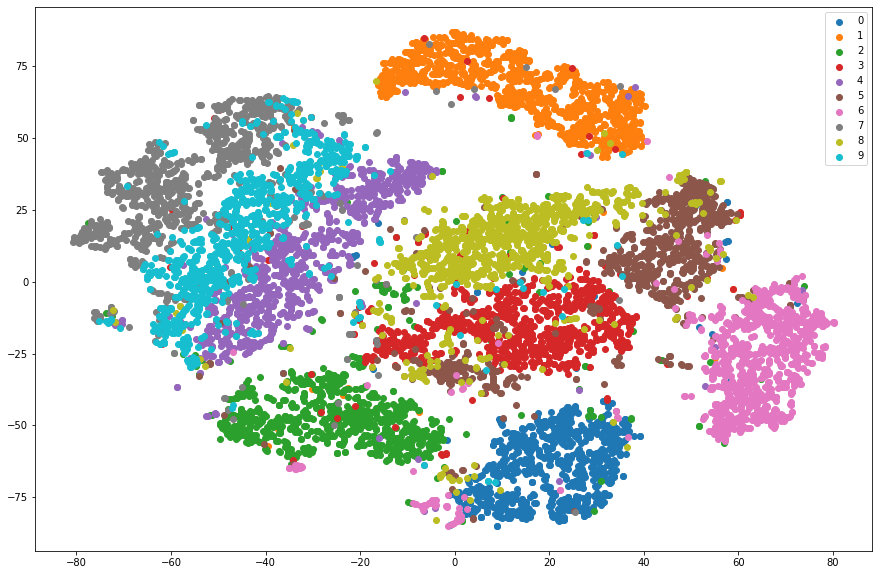

In [6]:
plt.figure(figsize=(15,10))

for c, ids in zip(mcolors.TABLEAU_COLORS, [str(i) for i in range(10)]):
    plt.scatter(x_embedded[y == ids, 0], x_embedded[y == ids, 1], c=c, label=ids)
plt.legend()
plt.show()

Jak widać na powyższym wykresie istnieją klasy, które wzajemnie na siebie nachodzą.  
Przykładem mogą być:  
    - 3 i 8  
    - 3 i 5  
    - 5 i 8  
    - 4 i 9  
    - 7 i 9  
Do dalszych zadań wybieramy klasę 3 i 8 

In [7]:
digit_filter = np.where((y == '3') | (y == '8'))
x_filtered, y_filtered = x_pca[digit_filter], y[digit_filter]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, train_size=0.8)
x_train.shape

(1616, 30)

## Bagging

Każdy z 5 klasyfikatorów jest trenowany za pomocą pozdbioru o wielkości 40% calego zbioru.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [9]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, max_samples=0.4, bootstrap=True) 
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9679012345679012

Definujemy fukncje pomocnicze do obliczania wyników klasyfikacji oraz ich graficznej prezentacji

In [10]:
def ensemble(Clf, estimators=[5], samples=[0.9], features=[0.9], params={}):
    result = pd.DataFrame(columns=['n_estimators', 'max_features', 'max_samples', 'score_f1', 'score'])
    for n_estimators in estimators:
        for max_samples in samples:
            for max_features in features:
                clf = Clf(max_features=max_features, n_estimators=n_estimators, max_samples=max_samples, **params)
                clf.fit(x_train, y_train)
                pred = clf.predict(x_test)
                row = { 'n_estimators':n_estimators,
                        'max_samples':max_samples,
                        'max_features':max_features,
                        'score': clf.score(x_test, y_test),
                        'score_f1': f1_score(y_test, pred, average='weighted')
                      }
                result = result.append(row, ignore_index=True)
    return result

    
def draw_heatmap(param1, param2, df, score='score'):
    score = df.pivot(param1, param2, score)
    plt.figure(figsize=(10,10))
    sns.heatmap(score,annot=True, cmap='coolwarm')

Obserwujemy zmianę dokładności klasyfikacji i F1 dla wzrastającej liczby klasyfikatorów w zespole i liczby przykładów, na których uczone są klasyfikatory proste.

In [11]:
estimators = range(5, 51, 5)
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap": True} # bootstrap = True zapewnia losowość podzbiorów danych
result = ensemble(BaggingClassifier, estimators=estimators, samples=samples, params=params)
result

,n_estimators,max_features,max_samples,score_f1,score
0,5.0,0.9,0.1,0.960479,0.960494
1,5.0,0.9,0.2,0.965432,0.965432
2,5.0,0.9,0.3,0.970366,0.970370
3,5.0,0.9,0.4,0.977776,0.977778
4,5.0,0.9,0.5,0.970370,0.970370
...,...,...,...,...,...
95,50.0,0.9,0.6,0.977776,0.977778
96,50.0,0.9,0.7,0.977776,0.977778
97,50.0,0.9,0.8,0.977776,0.977778
98,50.0,0.9,0.9,0.980247,0.980247


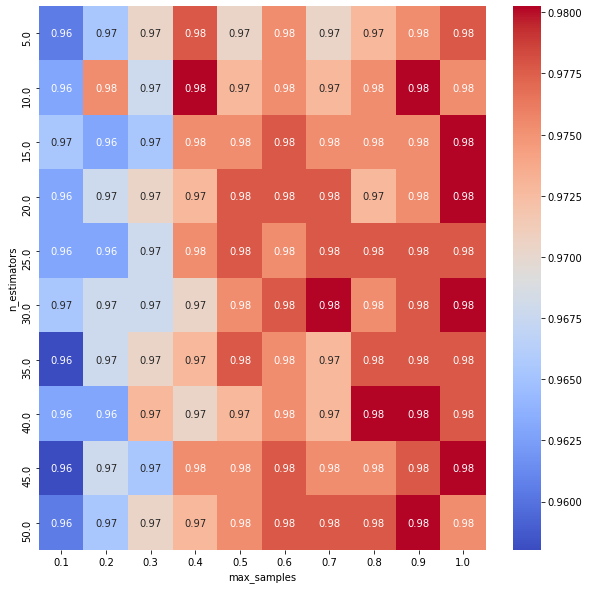

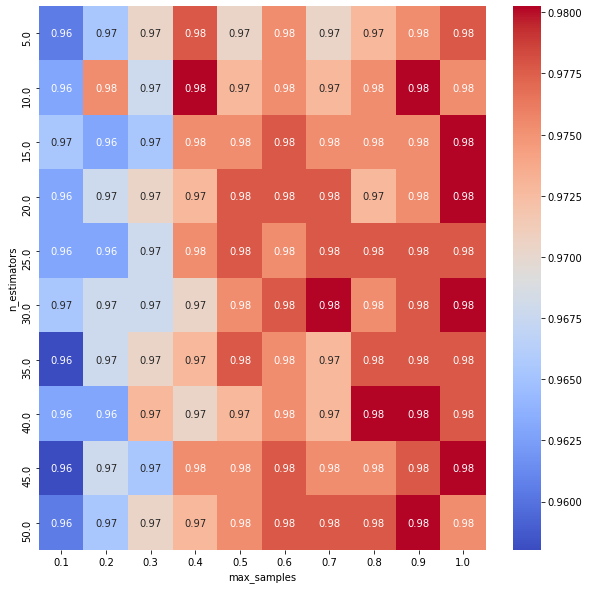

In [12]:
# dokładność klasyfikacji
draw_heatmap('n_estimators', 'max_samples', result)

# F1
draw_heatmap('n_estimators', 'max_samples', result, score='score_f1')

### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji. Porównać wynik klasycznego baggingu z wynikami dla VotingClassifier(z opcją voting='hard' oraz voting='soft')

In [35]:

clf1 = RandomForestClassifier(n_estimators=50, random_state=1)
clf2 = SVC(probability=True)
c = VotingClassifier(estimators=[('rfc', clf1)], voting='hard')
cc = c.fit(x_train, y_train)
print('rfc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('svc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('rfc', clf1),('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('rfc svc hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('rfc', clf1)], voting='soft')
cc = c.fit(x_train, y_train)
print('rfc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('svc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('rfc', clf1),('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('rfc svc soft',cc.score(x_test, y_test))

rfc hard 0.9629629629629629
svc hard 0.980246913580247
rfc svc hard 0.9604938271604938
rfc soft 0.9629629629629629
svc soft 0.980246913580247
rfc svc soft 0.9753086419753086


## Random Subspace
Do trenowania każdego z klasyfikatorów wykorzystany jest cały zbiór danych, lecz tylko połowa cech.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [14]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, bootstrap_features=True, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9604938271604938

Teraz obserwujemy zmienę dokładność klasyfikacji i F1 dla Random Subspace.

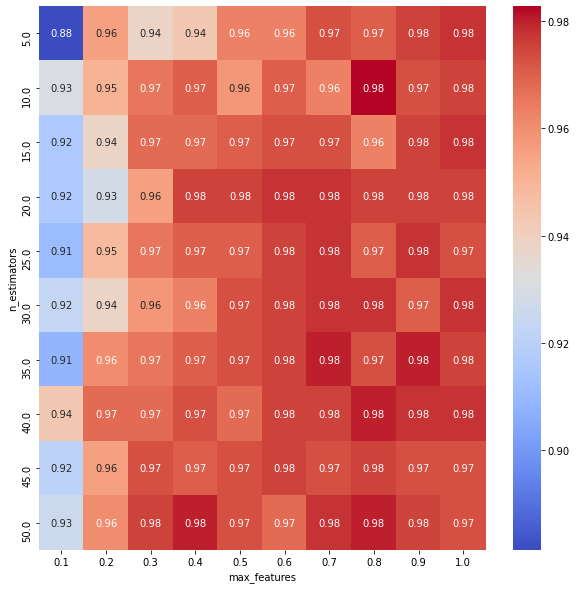

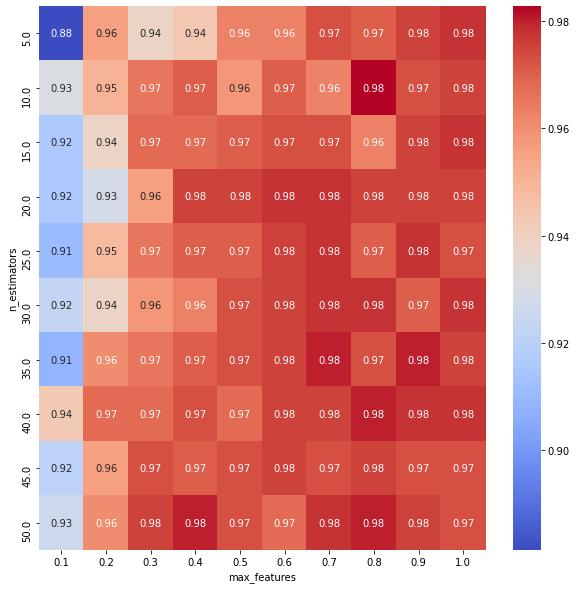

In [36]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True} # zapewnia losowość pozdbioru cech

result = ensemble(BaggingClassifier, estimators=estimators, features=features, params=params)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji. Porównać wynik otrzymany dla random subspace z wynikami dla VotingClassifier(z opcją voting='hard' oraz voting='soft')

In [37]:
clf1 = RandomForestClassifier(n_estimators=50, random_state=1)
clf2 = SVC(probability=True)
c = VotingClassifier(estimators=[('rfc', clf1)], voting='hard')
cc = c.fit(x_train, y_train)
print('rfc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('svc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('rfc', clf1),('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('rfc svc hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('rfc', clf1)], voting='soft')
cc = c.fit(x_train, y_train)
print('rfc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('svc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('rfc', clf1),('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('rfc svc soft',cc.score(x_test, y_test))

rfc hard 0.9629629629629629
svc hard 0.980246913580247
rfc svc hard 0.9604938271604938
rfc soft 0.9629629629629629
svc soft 0.980246913580247
rfc svc soft 0.9753086419753086


## Random Patches
Jest to połączenie klasycznego Baggingu i RandomSubspace.

Każdy z klasyfikatorów jest trenowany na podzbiorze danych oraz podzbiorze cech.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html


In [ ]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, 
                               bootstrap_features=True, max_features=0.5, max_samples=0.4)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

Teraz obserwujemy zmianę dokładności klasyfikacji i F1 w zależności od wielkości podzbioru danych i cech.

In [ ]:
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True, "bootstrap": True }

result = ensemble(BaggingClassifier, features=features, samples=samples, params=params)

draw_heatmap('max_samples', 'max_features', result)

draw_heatmap('max_samples', 'max_features', result, score='score_f1')

### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji. Porównać wynik otrzymany dla random patches z wynikami dla VotingClassifier(z opcją voting='hard' oraz voting='soft')

In [38]:
clf1 = RandomForestClassifier(n_estimators=50, random_state=1)
clf2 = SVC(probability=True)
c = VotingClassifier(estimators=[('rfc', clf1)], voting='hard')
cc = c.fit(x_train, y_train)
print('rfc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('svc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('rfc', clf1),('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('rfc svc hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('rfc', clf1)], voting='soft')
cc = c.fit(x_train, y_train)
print('rfc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('svc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('rfc', clf1),('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('rfc svc soft',cc.score(x_test, y_test))

rfc hard 0.9629629629629629
svc hard 0.980246913580247
rfc svc hard 0.9604938271604938
rfc soft 0.9629629629629629
svc soft 0.980246913580247
rfc svc soft 0.9753086419753086


## AdaBoost
Jest to metoda, która dla nowo tworzonych kopi klasyfikatorów uwzględnia dodatkowo wagi nieprawidłowo sklasyfikowanych instancji, tak aby mogły się one skoncentrować na bardziej skomplikowanych przypadkach.  
Domyślnie jako klasyfikator bazowy używany jest DecisionTreeClassifier.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [39]:
classifier = AdaBoostClassifier(n_estimators=5, random_state=7)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.8765432098765432

Teraz obserwujemy zmianę dokładności klasyfikacji i F1 dla AdaBoost.

In [40]:
estimators = range(5, 101, 5)

result = pd.DataFrame(columns=['n_estimators', 'score', 'score_f1'])
for n_estimators in estimators:
    clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=7)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    row = { 'n_estimators':n_estimators,
            'score': clf.score(x_test, y_test),
            'score_f1': f1_score(y_test, pred, average='weighted')
          }
    result = result.append(row, ignore_index=True)
result

,n_estimators,score,score_f1
0,5.0,0.876543,0.876466
1,10.0,0.908642,0.908648
2,15.0,0.925926,0.925939
3,20.0,0.918519,0.918533
4,25.0,0.930864,0.930876
5,30.0,0.940741,0.940752
6,35.0,0.945679,0.945685
7,40.0,0.953086,0.953095
8,45.0,0.948148,0.948156
9,50.0,0.948148,0.948156


In [41]:
result.score.max(), result.score.idxmax()

(0.9629629629629629, 12)

In [42]:
result.score_f1.max(), result.score_f1.idxmax()

(0.9629602509680126, 12)

## Random Forest
Jest to metoda oparta o las drzew uczących. Każde z nich uczone jest na losowo wybranym podzbiorze danych wraz z podzbiorem cech. Skutkuje to zmniejszoną korelacją pomiędzy poszczególnymi drzewami.  
Poniżej przedstawiono wynik klasyfikacji dla 5 klasyfikatorów oraz zbiorze cech równym połowie początkowego zbioru.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [88]:
classifier = RandomForestClassifier(n_estimators=5, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9616368286445013

Teraz obserwujemy zmianę dokładności klasyfikacji i F1 dla Random Forest.


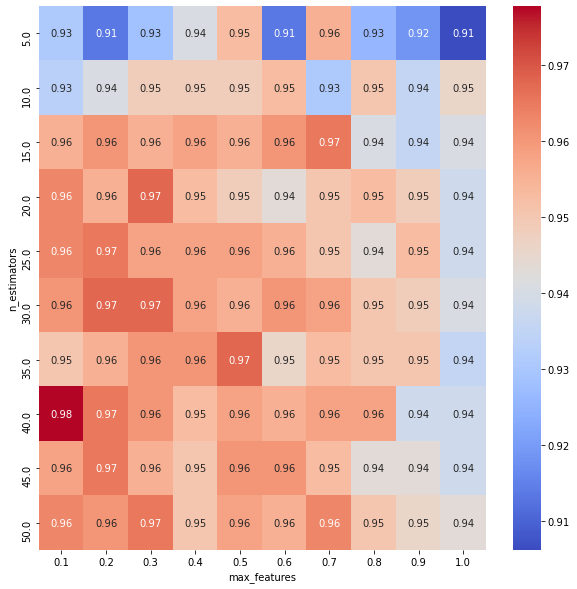

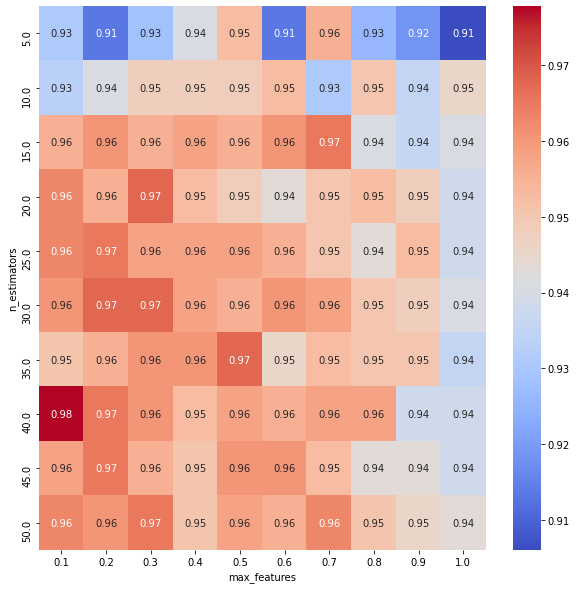

In [44]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

result = ensemble(RandomForestClassifier, estimators=estimators, features=features)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

## Zadanie indywidualne

1. Przetransformować zbiór FMNIST używając PCA do przestrzeni 30D. Następnie wybrać 2 trudno rozdzielane klasy

In [69]:
import tensorflow as tf
from sklearn.utils import resample
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x,y = resample(x_train, y_train, n_samples=10000, replace=False, random_state=0)
x = x.reshape(10000,-1)

In [70]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(30)
x_pca = pca.fit_transform(x_scaled)

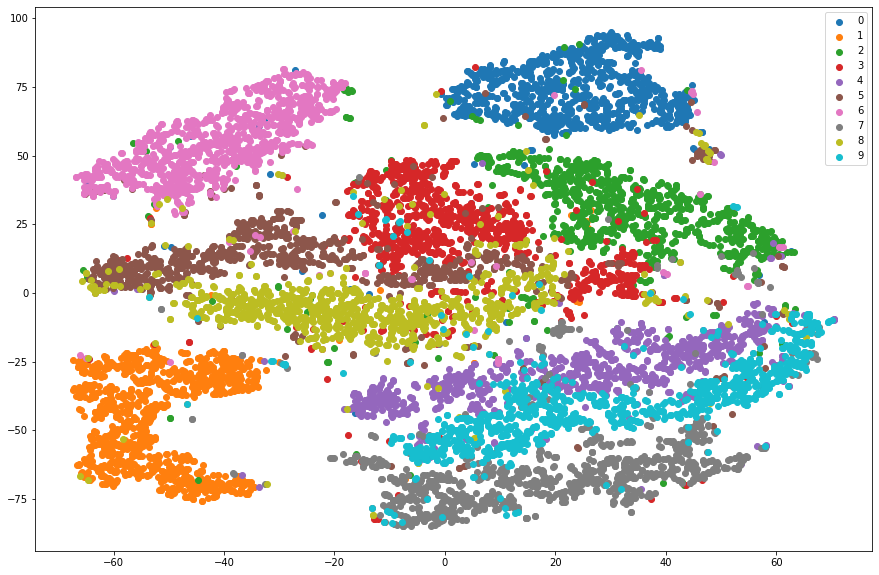

In [71]:
x_embedded = TSNE(n_components=2).fit_transform(x_pca)
plt.figure(figsize=(15,10))

for c, ids in zip(mcolors.TABLEAU_COLORS, [i for i in range(10)]):
    plt.scatter(x_embedded[y == ids, 0], x_embedded[y == ids, 1], c=c, label=ids)
plt.legend()
plt.show()

In [75]:
digit_filter = np.where((y == 2) | (y == 8))
x_filtered, y_filtered = x_pca[digit_filter], y[digit_filter]
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, train_size=0.8)
x_train.shape

(1564, 30)

2. Sprawdzić jak działa klasyczny Bagging dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów i wielkości podzbioru danych, na których są uczone klasyfikatory  
    b) jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji.

In [76]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, max_samples=0.4, bootstrap=True) 
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.979539641943734

In [77]:
estimators = range(5, 51, 5)
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap": True} # bootstrap = True zapewnia losowość podzbiorów danych
result = ensemble(BaggingClassifier, estimators=estimators, samples=samples, params=params)
result

,n_estimators,max_features,max_samples,score_f1,score
0,5.0,0.9,0.1,0.964189,0.964194
1,5.0,0.9,0.2,0.979537,0.979540
2,5.0,0.9,0.3,0.979540,0.979540
3,5.0,0.9,0.4,0.969299,0.969309
4,5.0,0.9,0.5,0.984653,0.984655
...,...,...,...,...,...
95,50.0,0.9,0.6,0.976981,0.976982
96,50.0,0.9,0.7,0.979537,0.979540
97,50.0,0.9,0.8,0.982096,0.982097
98,50.0,0.9,0.9,0.979537,0.979540


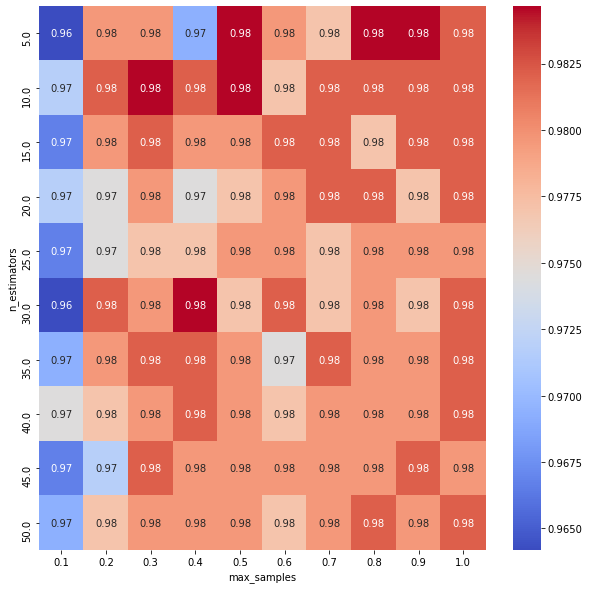

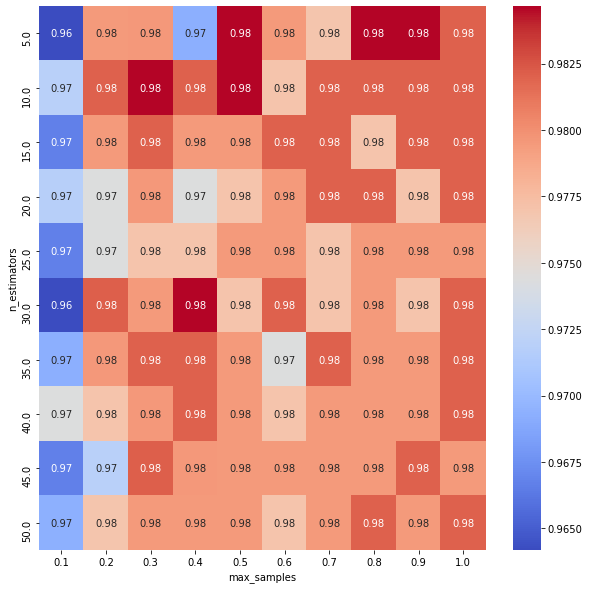

In [78]:
# dokładność klasyfikacji
draw_heatmap('n_estimators', 'max_samples', result)

# F1
draw_heatmap('n_estimators', 'max_samples', result, score='score_f1')

In [79]:
from sklearn.naive_bayes import GaussianNB

clf1 = RandomForestClassifier(n_estimators=50, random_state=1)
clf2 = SVC(probability=True)
clf3 = GaussianNB()

c = VotingClassifier(estimators=[('rfc', clf1)], voting='hard')
cc = c.fit(x_train, y_train)
print('rfc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('svc hard',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('rfc', clf1),('svc', clf2)], voting='hard')
cc = c.fit(x_train, y_train)
print('rfc svc hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('rfc', clf1),('svc', clf2), ('gnb', clf3)], voting='hard')
cc = c.fit(x_train, y_train)
print('rfc svc gnb hard',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('rfc', clf1)], voting='soft')
cc = c.fit(x_train, y_train)
print('rfc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('svc soft',cc.score(x_test, y_test))


c = VotingClassifier(estimators=[('rfc', clf1),('svc', clf2)], voting='soft')
cc = c.fit(x_train, y_train)
print('rfc svc soft',cc.score(x_test, y_test))

c = VotingClassifier(estimators=[('rfc', clf1),('svc', clf2),('gnb', clf3)], voting='soft')
cc = c.fit(x_train, y_train)
print('rfc svc gnb soft',cc.score(x_test, y_test))

rfc hard 0.9744245524296675
svc hard 0.9820971867007673
rfc svc hard 0.9744245524296675
rfc svc gnb hard 0.9769820971867008
rfc soft 0.9744245524296675
svc soft 0.9820971867007673
rfc svc soft 0.9820971867007673
rfc svc gnb soft 0.9744245524296675


3. Sprawdzić jak działa RandomSubspace dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów i wielkości podzbioru cech, na których są uczone klasyfikatory  
    b) jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji.

In [81]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, bootstrap_features=True, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9565217391304348

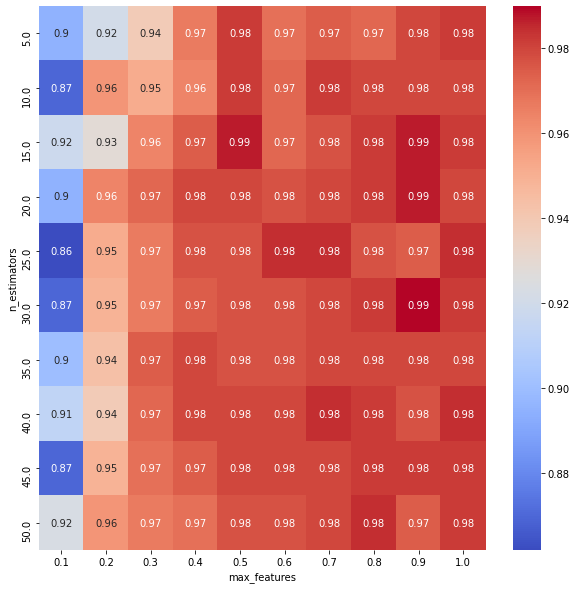

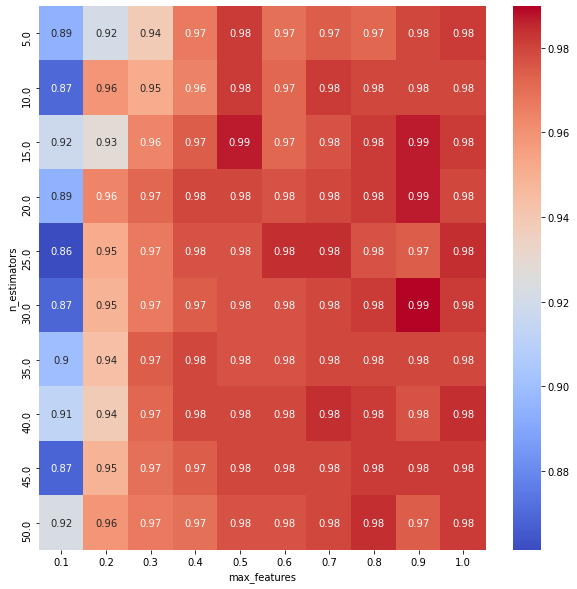

In [80]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True} # zapewnia losowość pozdbioru cech

result = ensemble(BaggingClassifier, estimators=estimators, features=features, params=params)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

4. Sprawdzić jak działa RandomPatches dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej wielkości pozdzbioru danych i wielkości podzbioru cech, na których są uczone klasyfikatory  
    b) jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji.

In [82]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, 
                               bootstrap_features=True, max_features=0.5, max_samples=0.4)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9616368286445013

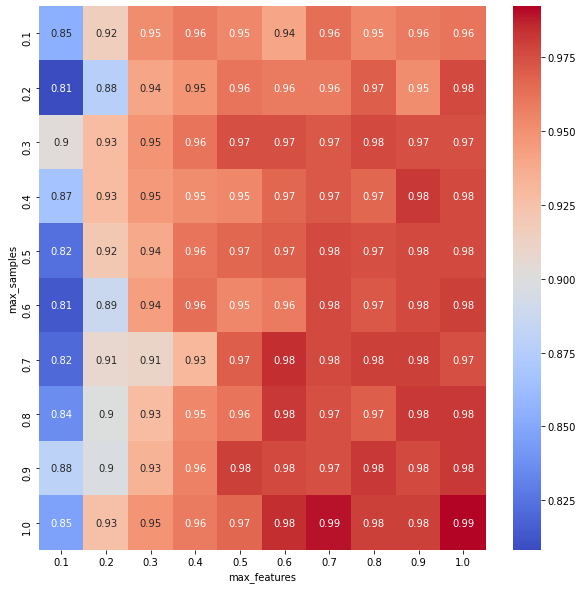

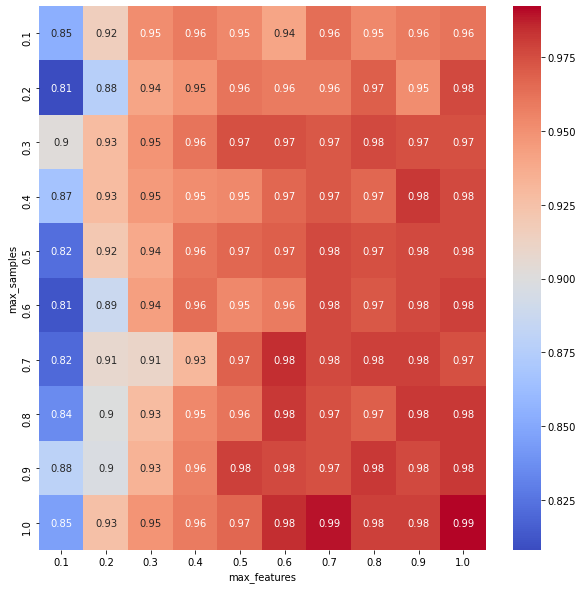

In [83]:
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True, "bootstrap": True }

result = ensemble(BaggingClassifier, features=features, samples=samples, params=params)

draw_heatmap('max_samples', 'max_features', result)

draw_heatmap('max_samples', 'max_features', result, score='score_f1')

5. Sprawdzić jak działa AdaBoost dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów

In [84]:
classifier = AdaBoostClassifier(n_estimators=5, random_state=7)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9156010230179028

In [85]:
estimators = range(5, 101, 5)

result = pd.DataFrame(columns=['n_estimators', 'score', 'score_f1'])
for n_estimators in estimators:
    clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=7)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    row = { 'n_estimators':n_estimators,
            'score': clf.score(x_test, y_test),
            'score_f1': f1_score(y_test, pred, average='weighted')
          }
    result = result.append(row, ignore_index=True)
result

,n_estimators,score,score_f1
0,5.0,0.915601,0.915612
1,10.0,0.913043,0.913051
2,15.0,0.938619,0.938619
3,20.0,0.959079,0.959085
4,25.0,0.959079,0.959083
5,30.0,0.959079,0.959083
6,35.0,0.959079,0.959079
7,40.0,0.959079,0.959083
8,45.0,0.961637,0.961639
9,50.0,0.964194,0.964198


In [86]:
result.score.max(), result.score.idxmax()

(0.979539641943734, 17)

In [87]:
result.score_f1.max(), result.score_f1.idxmax()

(0.9795415161913574, 17)

6. Sprawdzić jak działa RandomForest dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów i wielkości podzbioru cech, na których są uczone klasyfikatory

In [89]:
classifier = RandomForestClassifier(n_estimators=5, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.969309462915601

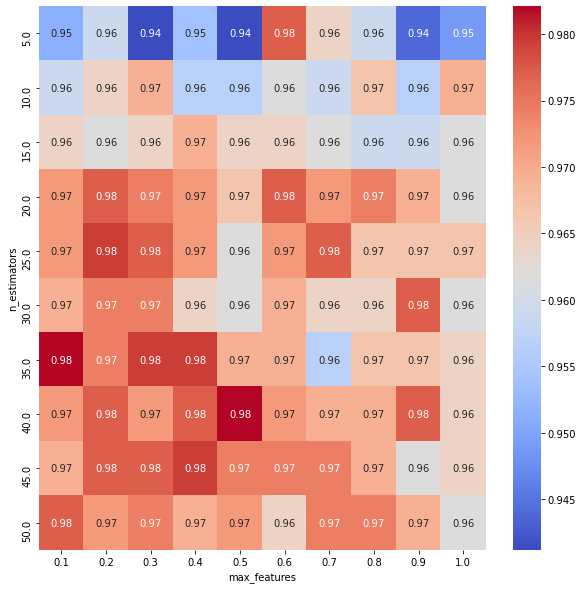

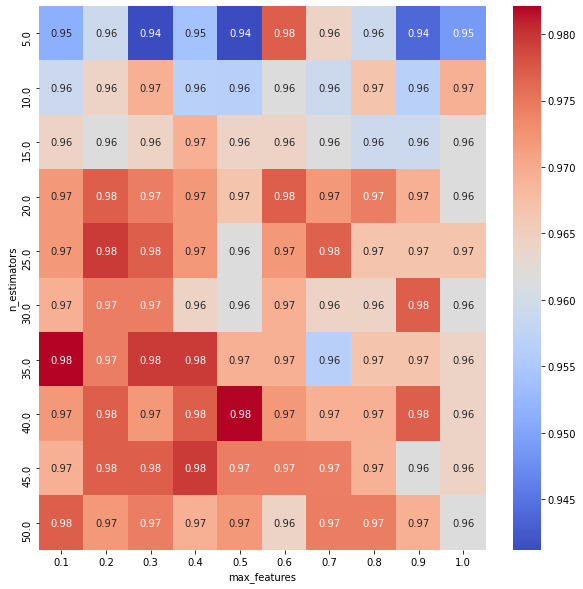

In [90]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

result = ensemble(RandomForestClassifier, estimators=estimators, features=features)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')